In [1]:
%pylab inline
from __future__ import division
import numpy as np
import deltasigma as ds
from scipy.signal import lti, ss2zpk, lfilter

Populating the interactive namespace from numpy and matplotlib


# MASH 2-2 cascade
## Introduction

We will simulate here a 2-2 MASH cascade.

The example is taken from Richard Schreier. The package used here -- `python-deltasigma` -- is a port of R. Schreier's MATLAB Delta-Sigma toolbox, available at: http://www.mathworks.com/matlabcentral/fileexchange. The credit goes to him for all algorithms employed.

## Modulator description

Each modulator in the cascade is described by the ABCD matrix:

In [ ]:
ABCD1 = [[1., 0., 1., -1.],
         [1., 1., 0., -2.],
         [0., 1., 0., 0.]]
ABCD1 = np.array(ABCD1, dtype=np.float64)

Each quantizer has 9 levels.

We need to describe the modulator in terms of its ABCD matrix:

In [ ]:
ABCD = [[1, 0, 0, 0, 1, -1, 0],
        [1, 1, 0, 0, 0, -2, 0],
        [0, 1, 1, 0, 0, 0, -1],
        [0, 0, 1, 1, 0, 0, -2],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]]
ABCD = np.array(ABCD, dtype=np.float64)

The modulator will have two quantizer, each of them having 9 levels, or slightly more than 3 bit. For this reason `nlev` is set to an array.

In [4]:
nlev = [9, 9]

## Transfer functions

We can now calculate the transfer functions associated with the modulator.

Notice there will be 6 of them, **4 NTFs**:

1. $NTF_{0,0}$: from the quantization noise injected by the 1st quantizer, to the output of the 1st DSM.
2. $NTF_{1,0}$: from the quantization noise injected by the 1st quantizer, to the output of the 2nd DSM.
3. $NTF_{1,1}$: from the quantization noise injected by the 2nd quantizer, to the output of the 2nd DSM.
4. $NTF_{0,1}$: Theoretically it also exists a transfer function from the quantization noise injected by the 2nd quantizer, to the output of the 1st DSM. Since the signal connections between the blocks are unidirectional, the noise added downstream cannot affect the signals upstream, and this transfer function will be null.

And **2 STFs**:

1. $STF_0$: From the signal input to the output of the 1st DSM.
2. $STF_1$: From the signal input to the output of the 2nd DSM.

In [5]:
k = [1., 1.]
ntfs, stfs = ds.calculateTF(ABCD, k)

//anaconda/lib/python2.7/site-packages/scipy/signal/filter_design.py:1055: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


### Noise transfer to the first output 

In [6]:
print "NTF_00:\n"
print ds.pretty_lti(ntfs[0, 0])

NTF_00:

 (z - 1)^2 
-----------
    z^2    


In [7]:
print "NTF_01:\n"
print ds.pretty_lti(ntfs[0, 1])

NTF_01:

0


### Noise transfer to the second output

In [8]:
print "NTF_10:\n"
print ds.pretty_lti(ntfs[1, 0])

NTF_10:

    (z - 0.5) 
-2 -----------
       z^4    


In [9]:
print "NTF_11:\n"
print ds.pretty_lti(ntfs[1, 1])

NTF_11:

 (z - 1)^2 
-----------
    z^2    


### NTF pole-zero plots

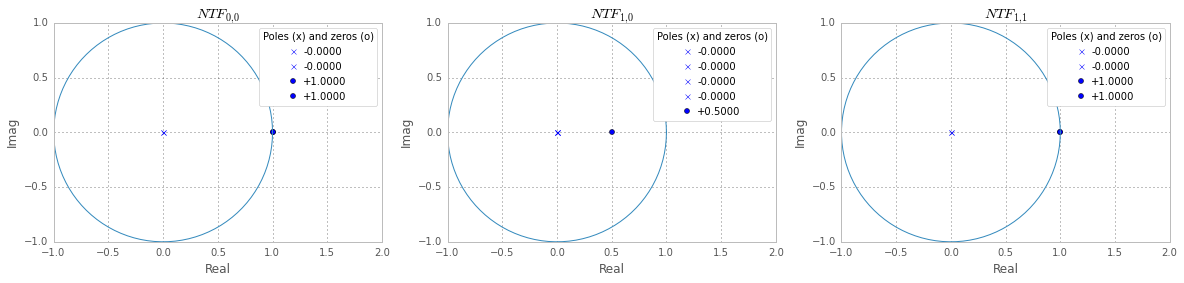

In [10]:
figure(figsize=(20, 6))
subplot(131)
title("$NTF_{0,0}$")
ds.plotPZ(ntfs[0, 0], showlist=True)
subplot(132)
title("$NTF_{1,0}$")
ds.plotPZ(ntfs[1, 0], showlist=True)
subplot(133)
title("$NTF_{1,1}$")
ds.plotPZ(ntfs[1, 1], showlist=True)

## Signal transfer functions

In [11]:
print "STF_0:\n"
print ds.pretty_lti(stfs[0])
print "\n\nSTF_1:\n"
print ds.pretty_lti(stfs[1])

STF_0:

  1  
-----
 z^2 


STF_1:

  1  
-----
 z^4 


### STF pole-zero plots

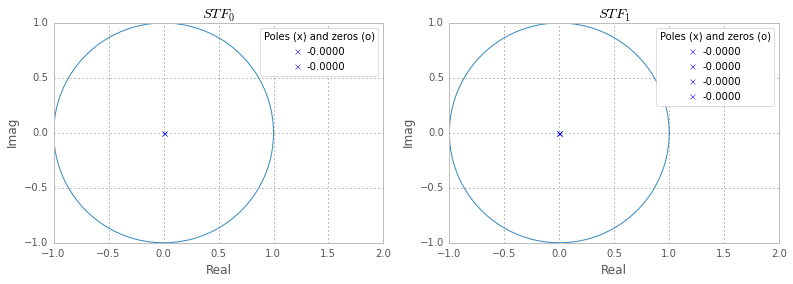

In [12]:
figure(figsize=(13, 4))
subplot(121)
title("$STF_{0}$")
ds.plotPZ(stfs[0], showlist=True)
subplot(122)
title("$STF_{1}$")
ds.plotPZ(stfs[1], showlist=True)

##Compensation of the quantization noise

Overall, the outputs $V_1$ and $V_2$ are given by:

$$V_1 = u\,z^{-2}+(1 - z^{-1})^2\,e_1$$ 

$$V_2 = u\, z^{-4} -2 (1 - 0.5z^{-1})\,z^{-3}\,e_1 +(1 - z^{-1})^2\,e_2 $$

It can be shown that, combining $V_1$ and $V_2$, multipliying each of them repectively by:

$$M_1 = z^{-3} - 2z^{-4}$$

and

$$M_2 = (1 - z^{-1})^2 $$

and then summing the result, gives an overall output $V_{OUT}$ with expression:

$$V_{TOT} = M_1V_1 + M_2V_2 = u\,z^{-4} + (1 - z^{-1})^4e_2.$$

The terms in $e_1$ do not appear in the above equation as they cancel out, the second modulator allows for the compensation of the quantization noise introduced by the first. Overall, as it can be seen by the above equation, the system provides fourth order noise shaping by employing two second order DS loops.

We briefly verify that numerically:

In [13]:
def zpk_multiply(a, b):
    za, pa, ka = ds._utils._get_zpk(a)
    zb, pb, kb = ds._utils._get_zpk(b)
    pa = pa.tolist() if hasattr(pa, 'tolist') else pa
    pb = pb.tolist() if hasattr(pb, 'tolist') else pb
    za = za.tolist() if hasattr(za, 'tolist') else za
    zb = zb.tolist() if hasattr(zb, 'tolist') else zb
    return ds.cancelPZ((za+zb, pa+pb, ka*kb))

v1n = zpk_multiply(ntfs[0, 0], ([2, -1], [1, 0, 0, 0, 0]))
v2n = zpk_multiply(ntfs[1, 0], ([1, 1], [0, 0], 1))
ntf_eq = zpk_multiply(ntfs[1, 1], ntfs[1, 1])
# compute v1n/v2n and check that it is equal to -1
res = zpk_multiply(v1n, (ds._utils._get_zpk(v2n)[1], ds._utils._get_zpk(v2n)[0], 1./ds._utils._get_zpk(v2n)[2]))
print "The quantization noise cancels out: %s" % (int(ds.pretty_lti(res)) == -1)

The quantization noise cancels out: True


The improvement in the NTF of the cascaded system may be better visualized plotting the spectras:

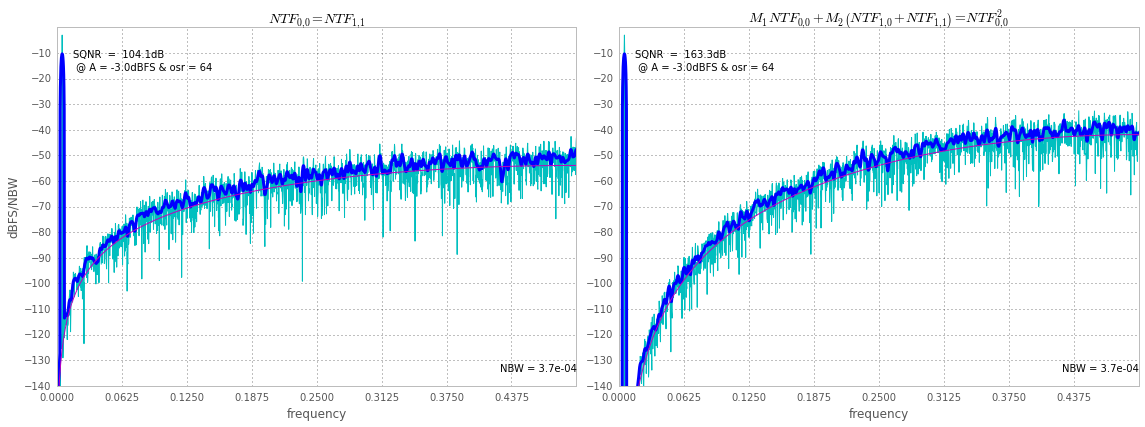

In [14]:
figure(figsize=(16, 6))
subplot(121)
ds.figureMagic(name='$NTF_{0,0} = NTF_{1,1}$')
ds.PlotExampleSpectrum(ntfs[1, 1], M=31)
ylabel('dBFS/NBW')
subplot(122)
ds.figureMagic(name='$M_1NTF_{0,0}+M_2\left(NTF_{1,0} + NTF_{1,1}\\right) = NTF_{0,0}^2$')
ds.PlotExampleSpectrum(ntf_eq, M=31)
#ds.PlotExampleSpectrum(ntfs[0, 0], M=31)
tight_layout()

## Numerical simulation of the 2-2 cascade and SNR improvement

Previously we simulated the NTF of a single modulator and the *expected* equivalent NTF when the two outputs are filtered and combined. Here we simulate the cascade of modulators with the ABCD matrix, computing their outputs $v_1$ and $v_2$, which are then numerically filtered and combined. Lastly, we check that the SNR improvement is as expected.

Notice we needed to scale down the amplitude of the input sine since a sine wave at -3dBFS was pushing the modulator to instability.

The filtering transfer functions $M_1$ and $M_2$ need to be expressed in terms of coefficients of $z^{-1}$ to be passed to `scipy`'s `lfilter`.

The coefficients are:

In [15]:
filtM1 = [0., 0., 0., 2., -1.]
filtM2 = [1., -2., 1.]

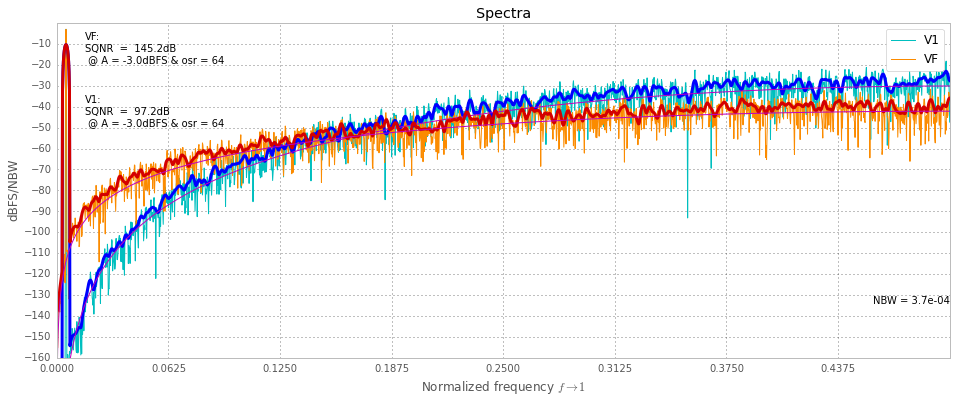

In [16]:
figure(figsize=(16, 6))
M = nlev[0] - 1
osr = 64
f0 = 0.
f1, f2 = ds.ds_f1f2(OSR=64, f0=0., complex_flag=False)
delta = 2
Amp = ds.undbv(-3) # Test tone amplitude, relative to full-scale.
f = 0.3 # will be adjusted to a bin
N = 2**12
f1_bin = np.round(f1*N)
f2_bin = np.round(f2*N)
fin = np.round(((1 - f)/2*f1 + (f + 1)/2*f2) * N)
# input sine
t = np.arange(0, N).reshape((1, -1))
u = Amp*M*np.cos((2*np.pi/N)*fin*t)
# simulate! don't forget to pass a list (or tuple or ndarray)
# as nlev value or the simulation will not be aware of the
# multiple quantizers
vx, _, xmax, y = ds.simulateDSM(u, ABCD, nlev=nlev)
# separate output #1 and output #2
v1 = vx[0, :]
v2 = vx[1, :]
# filter and combine
vf = lfilter(filtM1, [1.], v1) + lfilter(filtM2, [1.], v2)
# compute the spectra
window = ds.ds_hann(N)
NBW = 1.5/N
spec0 = np.fft.fft(vf*window)/(M*N/2)/ds.undbv(-6)
spec1 = np.fft.fft(v1*window)/(M*N/2)/ds.undbv(-6)
spec2 = np.fft.fft(v1*window)/(M*N/2)/ds.undbv(-6)
freq = np.linspace(0, 0.5, N/2 + 1)
plt.hold(True)
plt.plot(freq, ds.dbv(spec0[:N/2 + 1]), 'c', linewidth=1, label='V1')
plt.plot(freq, ds.dbv(spec2[:N/2 + 1]), '#fb8b00', linewidth=1, label='VF')

# smooth, calculate the theorethical response and the SNR for VF
spec0_smoothed = ds.circ_smooth(np.abs(spec0)**2., 16)
plt.plot(freq, ds.dbp(spec0_smoothed[:N/2 + 1]), 'b', linewidth=3)
Snn0 = np.abs(ds.evalTF(ntf_eq, np.exp(2j*np.pi*freq)))**2 * 2/12*(delta/M)**2
plt.plot(freq, ds.dbp(Snn0*NBW), 'm', linewidth=1)
snr0 = ds.calculateSNR(spec0[f1_bin:f2_bin + 1], fin - f1_bin)
msg = 'VF:\nSQNR  =  %.1fdB\n @ A = %.1fdBFS & osr = %.0f\n' % \
      (snr0, ds.dbv(spec0[fin]), osr)
plt.text(f0 + 1 / osr, - 15, msg, horizontalalignment='left',
         verticalalignment='center')

# smooth, calculate the theorethical response and the SNR for V1
spec1_smoothed = ds.circ_smooth(np.abs(spec1)**2., 16)
plt.plot(freq, ds.dbp(spec1_smoothed[:N/2 + 1]), '#d40000', linewidth=3)
Snn1 = np.abs(ds.evalTF(ntfs[0, 0], np.exp(2j*np.pi*freq)))**2 * 2/12*(delta/M)**2
plt.plot(freq, ds.dbp(Snn1*NBW), 'm', linewidth=1)
snr1 = ds.calculateSNR(spec1[f1_bin:f2_bin + 1], fin - f1_bin)
msg = 'V1:\nSQNR  =  %.1fdB\n @ A = %.1fdBFS & osr = %.0f\n' % \
      (snr1, ds.dbv(spec1[fin]), osr)
plt.text(f0 + 1/osr, - 15-30, msg, horizontalalignment='left',
         verticalalignment='center')

plt.text(0.5, - 135, 'NBW = %.1e ' % NBW, horizontalalignment='right',
         verticalalignment='bottom')
ds.figureMagic((0, 0.5), 1./16, None, (-160, 0), 10, None)
legend()
title("Spectra"); xlabel("Normalized frequency $f \\rightarrow 1$");ylabel("dBFS/NBW");

In [17]:
print "Overall the SNR improved by %g (!) at OSR=%d." % (snr0-snr1, osr)

Overall the SNR improved by 48.0339 (!) at OSR=64.


Notice that, as it often happen, it is not immediate to see by eye that the composed signal $v_f$ has better SNR than $v_1$ (or $v_2$).

In fact, consider the following plot of the signals from which the above spectra and SNRs were calculated:

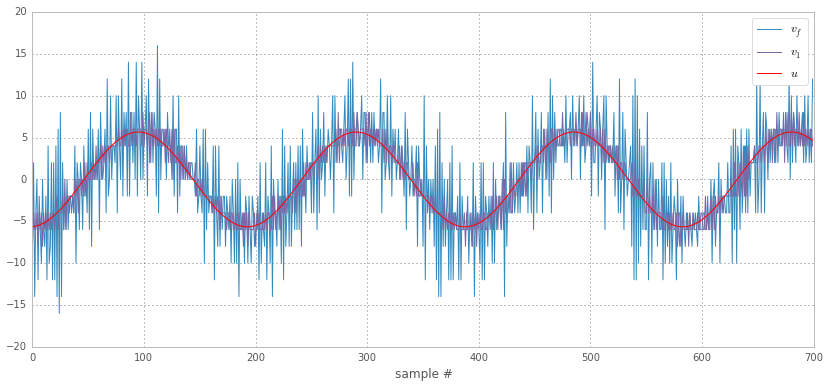

In [18]:
figure(figsize=(14, 6))
plot(vf[100:800], label='$v_f$')
plot(v1[100:800], label='$v_1$')
plot(u[:, 100:800].T, 'r', label='$u$')
xlabel('sample #'); legend();

## Conclusions

This notebook showed how it is possible, in the case of a Noise Shaping Multi-stage (MASH) cascade, to: 
* calculate the signal and noise transfer functions, 
* simulate the topology,
* filter and combine the outputs and
* evaluate the SNR improvement,

with `python-deltasigma`.

In [19]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, scipy, matplotlib, deltasigma

Software versions
Python 2.7.10 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 3.2.1
OS Darwin 14.4.0 x86_64 i386 64bit
numpy 1.9.2
scipy 0.16.0
matplotlib 1.4.3
deltasigma 0.2.2
Fri Aug 07 15:49:53 2015 CEST